# Twitter Sentiment Analysis using NLTK
by Afreed J
### Project Pipeline:
- Import Necessary Dependencies
- Read and Load the Dataset
- Exploratory Data Analysis
- Data Visualization of Target Variables
- Data Preprocessing
- Splitting our data into Train and Test sets.
- Transforming Dataset using TF-IDF Vectorizer
- Function for Model Evaluation
- Model Building
- Model Evaluation

In [24]:
import re
import numpy as np
import pandas as pd

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

# Read and load the dataset

In [25]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="latin1")

# EDA

In [26]:
# Top 3 records of data
df.head(3)

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire


Features in the data

In [28]:
df.columns

Index(['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY',
       '_TheSpecialOne_',
       '@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D'],
      dtype='object')

Let us first change the names of the columns

In [29]:
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df.head(1)

,target,ids,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


In [30]:
# Shape of the dataset
df.shape

(1599999, 6)

In [31]:
# Info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1599999 non-null  int64 
 1   ids     1599999 non-null  int64 
 2   date    1599999 non-null  object
 3   flag    1599999 non-null  object
 4   user    1599999 non-null  object
 5   text    1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


`df.info()` gives a concise summary of the dataset structure, data types, and missing values.
- As we can see that the date dtype is object, which has to be in Date format

In [32]:
# Checking for null values
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [33]:
# Check for no. of rows and columns
df.shape

(1599999, 6)

- There are 6 columns and 1600000 records

In [34]:
# Check unique target values
df['target'].unique()

array([0, 4])

In [35]:
# Get the Statistical analysis of the DataFrame
df.describe()

,target,ids
count,1.599999e+06,1.599999e+06
mean,2.000001e+00,1.998818e+09
std,2.000001e+00,1.935757e+08
min,0.000000e+00,1.467811e+09
25%,0.000000e+00,1.956916e+09
50%,4.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


1. Target Variable Analysis
- The target variable represents the class labels in the dataset.
- The minimum value is 0 and the maximum value is 4.

- The standard deviation is 2.0, showing a wide spread of class values across the dataset.
- The 25th percentile (Q1) is 0, the median (Q2) is 4, and the 75th percentile (Q3) is also 4.
- This indicates that a significant proportion of observations belong to the higher class labels, particularly class 4.

Overall, the target variable is categorical in nature but numerically encoded, making it suitable for classification tasks.

2. ID Column Analysis
- The ids column appears to be a unique identifier for each data record.
- The mean ID value is approximately 2.0 × 10⁹, with a minimum of 1.47 × 10⁹ and a maximum of 2.33 × 10⁹.
- The standard deviation (~1.94 × 10⁸) indicates that the ID values are widely spread.
- Since IDs are meant only for identification and do not carry predictive information, they should not be used as a feature during model training.

In [36]:
# Checking for any duplicated values
df.nunique()

target          2
ids       1598314
date       774362
flag            1
user       659775
text      1581465
dtype: int64

In [37]:
# Convert Labels to Meaningful Form
df['sentiment'] = df['target'].map({0: 'Negative', 4: 'Positive'})

In [38]:
# Length of Tweets
df['tweet_length'] = df['text'].apply(len)
df['tweet_length'].describe()
# The tweet length distribution is right-skewed, with most tweets being short and a small number of longer tweets.

count    1.599999e+06
mean     7.409009e+01
std      3.644114e+01
min      6.000000e+00
25%      4.400000e+01
50%      6.900000e+01
75%      1.040000e+02
max      3.740000e+02
Name: tweet_length, dtype: float64

`Mean` (~ 74 characters):
On average, tweets in the dataset contain around 74 characters, suggesting that most tweets are short and concise, which is typical for Twitter data.

`Standard Deviation` (~ 36 characters):
The relatively high standard deviation indicates a wide variation in tweet lengths, meaning the dataset includes both very short and relatively long tweets.

`Minimum Length` (6 characters):
The shortest tweets contain only a few characters, which may include abbreviations, emojis, or short expressions.

`25th Percentile` (~ 44 characters):
About 25% of tweets are shorter than 44 characters, indicating a substantial portion of brief messages.

`Median` (≈ 69 characters):
Half of the tweets have a length below 69 characters, showing that the majority of tweets are well below Twitter’s character limit.

`75th Percentile` (~ 104 characters):
Around 75% of tweets have fewer than 104 characters, indicating that longer tweets are less common.

`Maximum Length` (374 characters):
The longest tweet in the dataset reaches 374 characters, likely representing extended tweets or combined text fields.

# Univariate Analysis:
Univariate data involves observations consisting of only one variable. 
For textual sentiment data, univariate analysis is crucial to:
- Identify structural properties of tweets
- Detect anomalies and noise
- Understand sentiment-wise behavioral patterns

### Sentiment distribution

In [39]:
df['sentiment'].value_counts()
df['sentiment'].value_counts(normalize=True)

sentiment
Positive    0.5
Negative    0.5
Name: proportion, dtype: float64

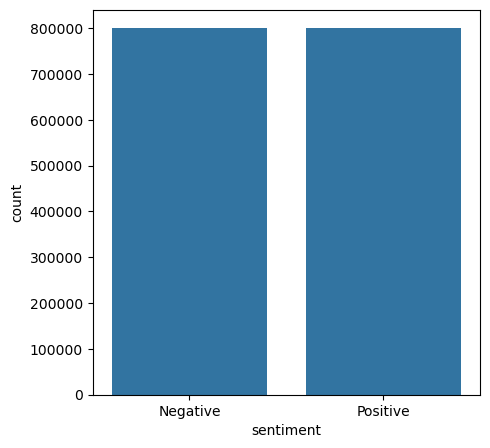

In [40]:
# Plot
plt.figure(figsize = (5,5))
sns.countplot(x='sentiment', data=df)
plt.show()

- From here we get to undertand that the data in the datset is perfectly balanced
- This eliminates class imbalance bias
- Entropy: Maximum (ideal for classification)

In [41]:
df['tweet_length'].describe()

count    1.599999e+06
mean     7.409009e+01
std      3.644114e+01
min      6.000000e+00
25%      4.400000e+01
50%      6.900000e+01
75%      1.040000e+02
max      3.740000e+02
Name: tweet_length, dtype: float64

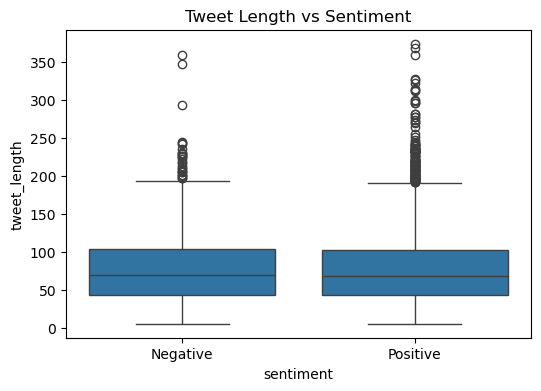

In [42]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='sentiment', y='tweet_length')
plt.title("Tweet Length vs Sentiment")
plt.show()

- Positive tweets are slightly longer on average.
- Negative tweets show higher variability (emotional expressions)

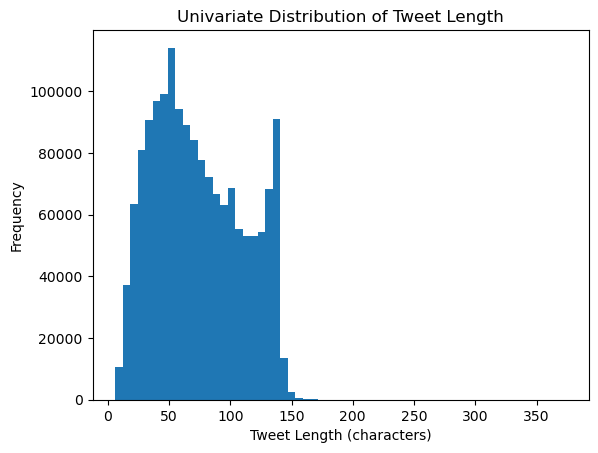

In [43]:
# Distribution Shape
plt.figure()
plt.hist(df['tweet_length'], bins=60)
plt.xlabel("Tweet Length (characters)")
plt.ylabel("Frequency")
plt.title("Univariate Distribution of Tweet Length")
plt.show()

- Distribution is positively skewed
- Majority of tweets are short (<120 characters)

Right-skewed distributions are common in social media text and justify:
- Robust models (SVM, Logistic Regression)

### Outlier Detection

In [44]:
Q1 = df['tweet_length'].quantile(0.25)
Q3 = df['tweet_length'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['tweet_length'] < Q1 - 1.5*IQR) | 
              (df['tweet_length'] > Q3 + 1.5*IQR)]
outliers.shape

(147, 8)

The output (147, 9) tells that there are 147 rows in this dataset that qualify as outliers, and the dataframe has 9 columns.
- Outliers represent less than 1% of data
- Safe to retain due to large dataset size
- Removing them offers negligible performance gain

In [45]:
# Tweet Length by Sentiment
df.groupby('sentiment')['tweet_length'].describe()

,count,mean,std,min,25%,50%,75%,max
sentiment,,,,,,,,
Negative,799999.0,74.301739,36.743255,6.0,44.0,70.0,104.0,359.0
Positive,800000.0,73.878433,36.135274,6.0,44.0,69.0,103.0,374.0


In [48]:
# Word Count Per Tweet
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['word_count'].describe()

count    1.599999e+06
mean     1.317615e+01
std      6.957979e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.200000e+01
75%      1.900000e+01
max      6.400000e+01
Name: word_count, dtype: float64

In [49]:
df['word_count'].describe()

count    1.599999e+06
mean     1.317615e+01
std      6.957979e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.200000e+01
75%      1.900000e+01
max      6.400000e+01
Name: word_count, dtype: float64

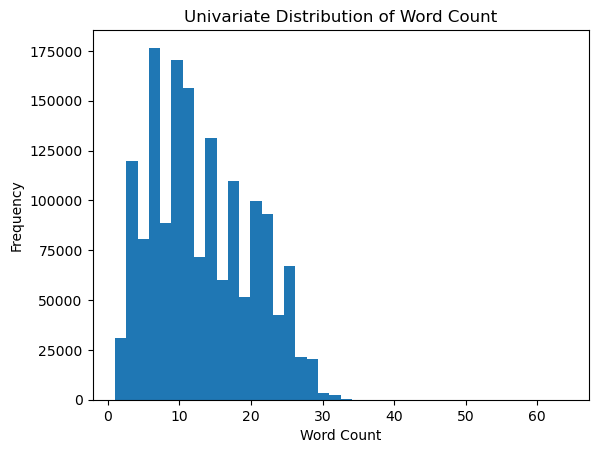

In [50]:
# Word Count Distribution
plt.figure()
plt.hist(df['word_count'], bins=40)
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Univariate Distribution of Word Count")
plt.show()

- Most tweets contain 5–20 words
- Word count follows a right-skewed distribution

In [ ]:
# Word Count Per Tweet
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['word_count'].describe()

In [ ]:
# Word Count by Sentiment
df.groupby('sentiment')['word_count'].mean()
# Negative tweets use slightly more words

# Final Takeaway
- Dataset is large, and well-balanced
- No missing values
- No serious data type issues
- Target variable is binary and evenly distributed

# Data Preprocessing

In [51]:
data=df[['text','target']]

In [52]:
# Replacing the values to ease understanding.
data.loc[:, 'target'] = data['target'].replace(4, 1)

In [53]:
# Printing unique values of target variables
data['target'].unique()

array([0, 1])

In [54]:
# Separating positive and negative tweets
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

In [55]:
# Taking one-fourth of the data so we can run it on our machine easily
data_pos = data_pos.iloc[:int(40000)]
data_neg = data_neg.iloc[:int(40000)]

In [56]:
# Combining positive and negative tweets
dataset = pd.concat([data_pos, data_neg])

In [57]:
# Making statement text in lowercase
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

39995    @mittec no problems with it as such but i had ...
39996                                          ow my head 
39997    anyway... not particularly looking foreward to...
39998    allergies or insomnia? doesn't matter the reason 
39999    @scottcabal i'm working in the the evening  bu...
Name: text, dtype: object

In [59]:
# Defining set containing all stopwords in English.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [60]:
# Cleaning and removing the above stop words list from the tweet text
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

799999                love @health4uandpets u guys r best!!
800000    im meeting one besties tonight! cant wait!! - ...
800001    @darealsunisakim thanks twitter add, sunisa! g...
800002    sick really cheap hurts much eat real food plu...
800003                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [61]:
# Cleaning and removing punctuations
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

39995    mittec no problems but literally spent 2 hours...
39996                                              ow head
39997    anyway not particularly looking foreward labs ...
39998              allergies insomnia doesnt matter reason
39999    scottcabal im working evening but could daytim...
Name: text, dtype: object

In [62]:
# Cleaning and removing repeating characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

39995    mitec no problems but literaly spent 2 hours c...
39996                                              ow head
39997    anyway not particularly loking foreward labs t...
39998                alergies insomnia doesnt mater reason
39999    scotcabal im working evening but could daytime...
Name: text, dtype: object

In [63]:
# Cleaning and removing URLs
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

39995    mitec no problems but literaly spent 2 hours c...
39996                                              ow head
39997    anyway not particularly loking foreward labs t...
39998                alergies insomnia doesnt mater reason
39999    scotcabal im working evening but could daytime...
Name: text, dtype: object

In [64]:
# Cleaning and removing numeric numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

39995    mitec no problems but literaly spent  hours cl...
39996                                              ow head
39997    anyway not particularly loking foreward labs t...
39998                alergies insomnia doesnt mater reason
39999    scotcabal im working evening but could daytime...
Name: text, dtype: object

## What is Tokenization in NLP?

Tokenization is the process of breaking text into smaller units, called tokens.
These tokens can be words, sub-words, characters, or sentences, depending on the task.

Tokenization is one of the first and most important steps in any NLP pipeline because machines cannot understand raw text directly.

Input text: `I am learning Natural Language Processing!`

After tokenization (word-level): `['I', 'am', 'learning', 'Natural', 'Language', 'Processing']`

Why Tokenization is Important

- Converts raw text into processable units
- Enables further NLP steps like:
- Stopword removal
- Stemming / Lemmatization
Vectorization (TF-IDF, Bag of Words)
Reduces ambiguity and noise in text data

Without tokenization, text preprocessing cannot proceed.

There are multiple types of Tokenization used, in this project we have used `Word Tokenization` ( Splits text into individual words. )

In [65]:
# Getting tokenization of tweet text
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

## What is Stemming in NLP?

Stemming is a text preprocessing technique in Natural Language Processing (NLP) that reduces words to their root or base form by removing prefixes or suffixes.

The goal of stemming is to treat different grammatical forms of a word as the same feature, thereby reducing vocabulary size and improving model efficiency.

Why Stemming is Used

In real-world text data:

- Words appear in many grammatical forms
- Treating each form separately increases noise
- Models become slower and less generalizable
- Stemming normalizes words by collapsing multiple forms into a single representation.

How Stemming Works

Stemming works by:
- Applying rule-based heuristics
- Removing common suffixes such as:`-ing`, `-ed`,`-s`, `-ly`, `-tion`
- It does not understand context or grammar

Because of this, stemming is:
- Fast
- Simple
- Less accurate than lemmatization.

When to Use Stemming

Use stemming when:
- Speed is important
- Dataset is very large

You are doing:
- Text classification
- Spam detection
- Sentiment analysis (basic)

Avoid stemming when:
- Exact word meaning matters
- Grammar and context are important

In [66]:
# Applying stemming
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    return [st.stem(word) for word in data]
dataset['text'] = dataset['text'].apply(stemming_on_text)
dataset['text'].head()

799999               [love, healthuandpet, u, guy, r, best]
800000    [im, mete, one, besti, tonight, cant, wait, gi...
800001    [darealsunisakim, thank, twiter, ad, sunisa, g...
800002    [sick, reali, cheap, hurt, much, eat, real, fo...
800003                       [lovesbroklyn, efect, everyon]
Name: text, dtype: object

## What is Lemmatization in NLP?
Lemmatization is a text preprocessing technique in Natural Language Processing (NLP) that converts words into their base or dictionary form, known as a lemma.

Unlike simple word truncation, lemmatization uses linguistic rules and vocabulary knowledge to ensure that the transformed word is meaningful and valid.
- Ex: Running  -->   Run
-    Cars     -->   Car

Why Lemmatization is Important

In text data, the same word can appear in many forms:

- tense (run, running, ran)
- number (car, cars)
- degree (good, better, best)

Lemmatization normalizes these variations so that the model treats them as the same concept, reducing redundancy and noise.

How Lemmatization Works

Lemmatization:

- Analyzes the context of a word
- Identifies its part of speech (POS) (noun, verb, adjective)
- Uses a lexical database to find the correct base form

This is why lemmatization is more accurate but computationally heavier.

When to Use Lemmatization

- Use lemmatization when:
- Text meaning matters (sentiment analysis, topic modeling)
- You want high-quality linguistic features
- Dataset size is manageable

In [67]:
# Applying lemmatizer
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

799999               [love, healthuandpet, u, guy, r, best]
800000    [im, mete, one, besti, tonight, cant, wait, gi...
800001    [darealsunisakim, thank, twiter, ad, sunisa, g...
800002    [sick, reali, cheap, hurt, much, eat, real, fo...
800003                       [lovesbroklyn, efect, everyon]
Name: text, dtype: object

In [68]:
# Separating input feature and label
X=data.text
y=data.target

## What is a Word Cloud?

A word cloud is a visual representation of text data where:
- Words appear with different sizes
- Larger words occur more frequently
- Smaller words occur less frequently

It helps you quickly understand the most dominant words in a corpus without reading all the text.

### Plot a cloud of words for negative tweets

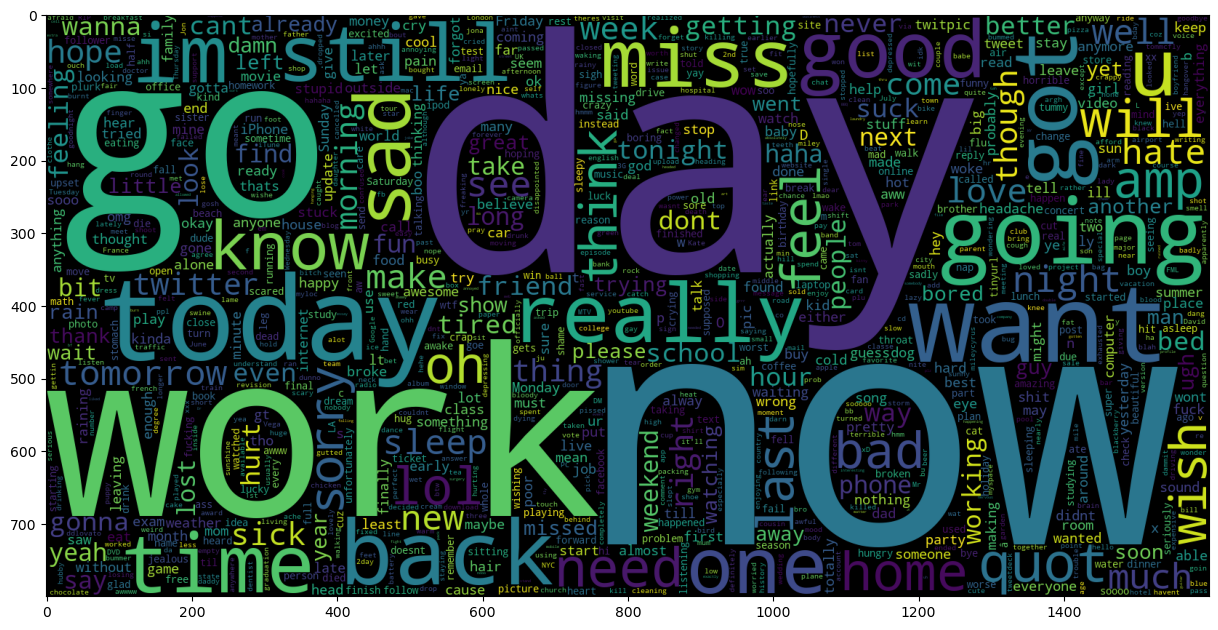

In [70]:
data_neg = data['text'][:800000]
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

### Plot a cloud of words for positive tweets

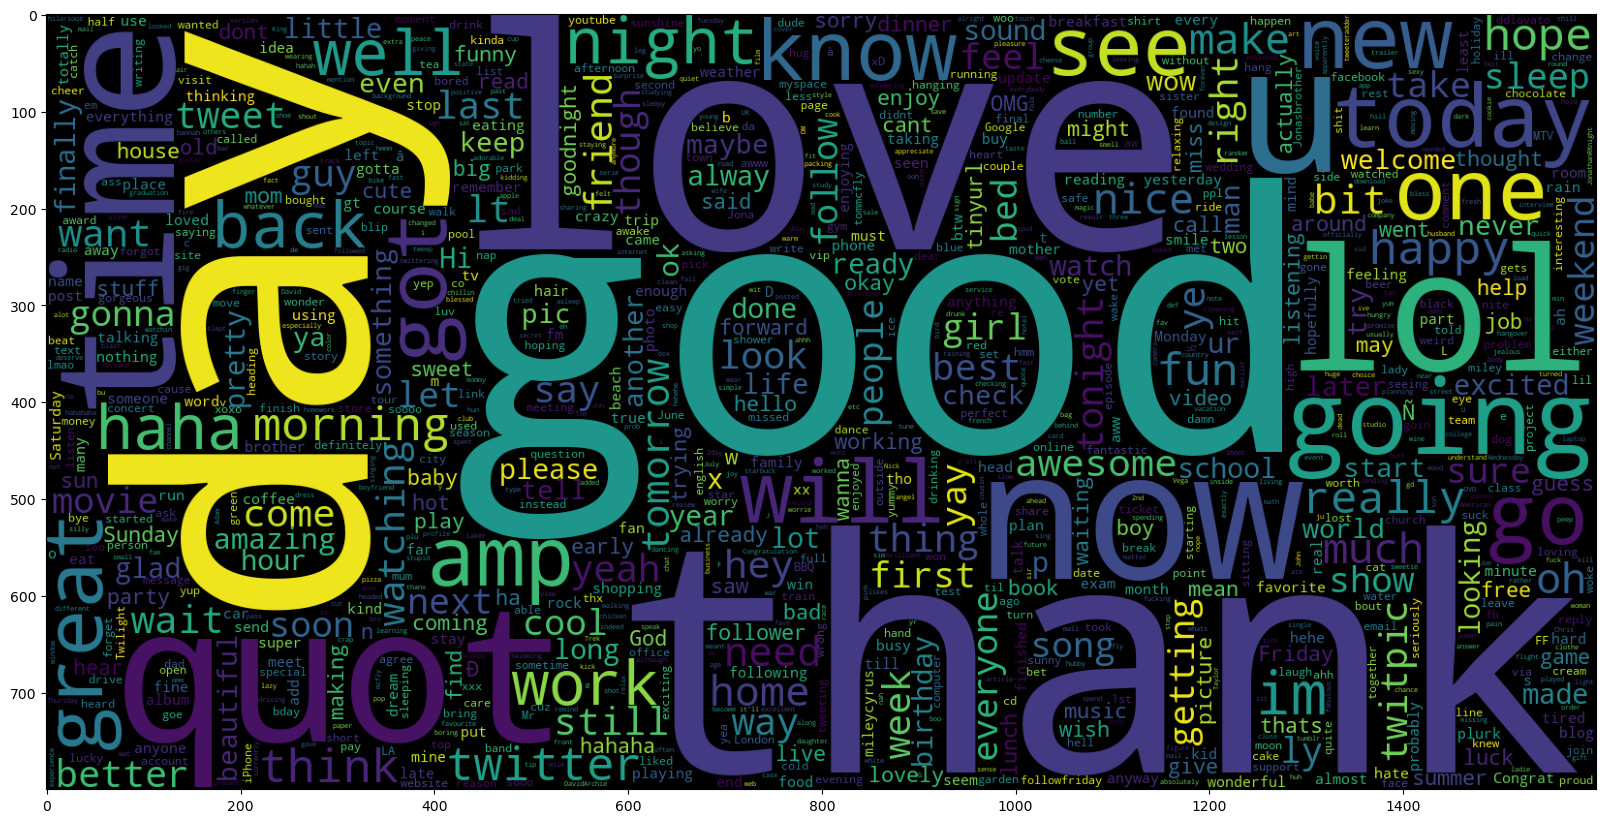

In [71]:
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

## Splitting Our Data Into Train and Test Subsets

In [72]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

## TF-IDF (Term Frequency–Inverse Document Frequency)

TF-IDF is a text-to-number transformation technique used in Natural Language Processing (NLP).

It converts text documents into numerical feature vectors that represent how important a word is to a document within a collection of documents.

### TF-IDF Has Two Components
1. Term Frequency (TF)

Measures how often a word appears in a document.

- `TF(word)`=
Total words in that document/
Number of times word appears in a document

Words appearing more often in a document get higher TF.

2. Inverse Document Frequency (IDF)

Measures how rare a word is across all documents.

- `IDF(word)` =log(Number of documents containing the word/Total number of documents)

Final `TF-IDF Score` : TF-IDF = TF×IDF

## Transforming the Dataset Using TF-IDF Vectorizer

In [74]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=800000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  800000


In [75]:
# Transform the data using TF-IDF Vectorizer
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

## Model Building

#### Function for Model Evaluation

In [77]:
def model_Evaluate(model):

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories = ['Negative', 'Positive']
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_percentages = [
        '{0:.2%}'.format(value)
        for value in cf_matrix.flatten() / np.sum(cf_matrix)
    ]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(
        cf_matrix,
        annot=labels,
        cmap='Blues',
        fmt='',
        xticklabels=categories,
        yticklabels=categories
    )

    plt.xlabel("Predicted values", fontdict={'size':14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size':14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size':18}, pad=20)
    plt.show()

## 1. Bernoulli Naive Bayes Classifier
Bernoulli Naive Bayes (BNB) is a probabilistic machine learning algorithm used for binary or boolean feature data, especially in text classification tasks such as sentiment analysis and spam detection.

Unlike other Naive Bayes variants, Bernoulli Naive Bayes focuses on the presence or absence of words, not how frequently they occur.

### How Bernoulli Naive Bayes Works
The classifier computes:

## P(Class∣Document) ∝ P(Class)× ∏P(word∣Class)
Where:

- P(Class) → prior probability of a class
- P(word | Class) → probability that a word appears in a document of that class

The class with the highest posterior probability is chosen.

#### Why Use Bernoulli Naive Bayes in NLP?

Bernoulli Naive Bayes is useful because:
- It performs well on short text (tweets, reviews)
- It handles binary features efficiently
- It is fast and memory-efficient
- It works well with TF-IDF (binary=True) or binary Bag-of-Words

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     40100
           1       0.80      0.81      0.80     39900

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



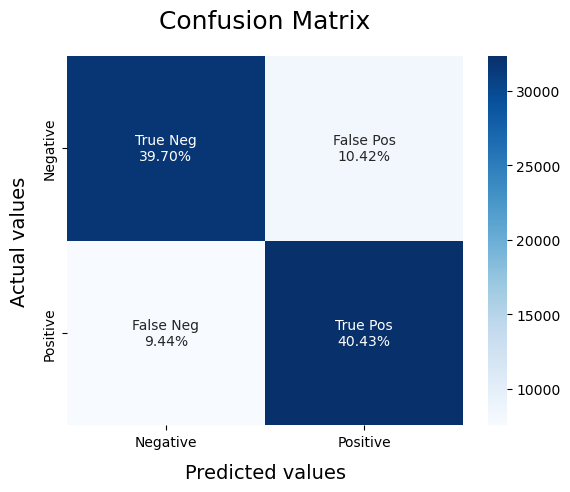

In [78]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

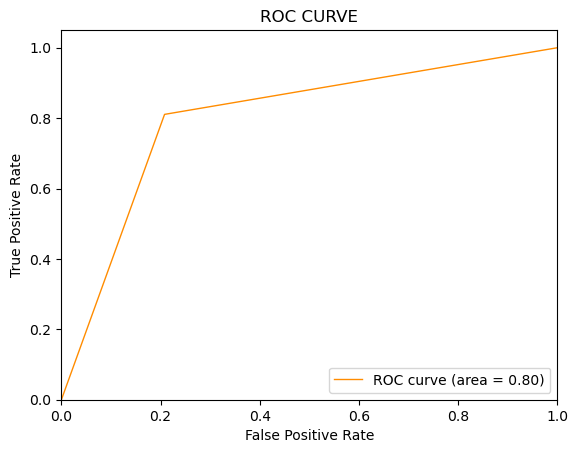

In [80]:
# Plot the ROC-AUC Curve for model-1
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

## 2. SVM (Support Vector Machine)

Support Vector Machine (SVM) is a powerful supervised learning algorithm used for classification tasks. In this project, SVM is used to classify tweets into sentiment classes (Positive / Negative) based on features extracted using TF-IDF vectorization.

Core Idea of SVM (In Simple Terms)

- SVM works by finding a decision boundary (hyperplane) that best separates different classes in the feature space.
- The goal is to maximize the margin
- Margin = distance between the hyperplane and the closest data points
- The closest points are called support vectors

A larger margin usually leads to better generalization on unseen data.

#### How SVM Works with TF-IDF

1. Tweets are converted into numerical vectors using TF-IDF
2. Each tweet becomes a point in high-dimensional space
3. SVM learns a linear boundary that separates sentiments
4. New tweets are classified based on which side of the boundary they fall on.

Linear SVM (Used for Text Classification)

For NLP tasks, a Linear SVM is preferred:
- Faster than non-linear kernels
- Scales well to millions of features
- Works efficiently with sparse matrices

              precision    recall  f1-score   support

           0       0.83      0.81      0.82     40100
           1       0.81      0.83      0.82     39900

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



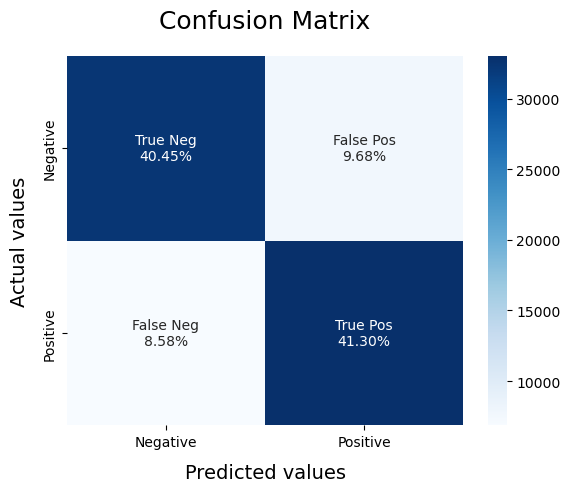

In [81]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

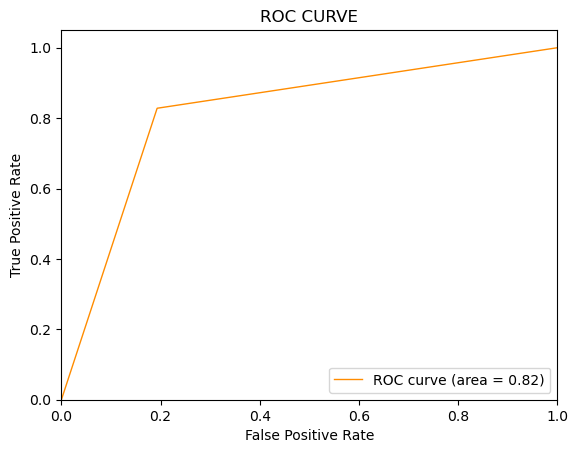

In [82]:
# Plot the ROC-AUC Curve for model-2
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

## 3. Logistic Regression
Logistic Regression is a supervised machine learning algorithm widely used for binary classification problems.
In this project, Logistic Regression is used to classify tweets into Positive or Negative sentiment using features generated by TF-IDF vectorization.

Core Idea of Logistic Regression

Despite its name, Logistic Regression is a classification algorithm, not a regression model.
- It computes a linear combination of input features
- Passes the result through a sigmoid (logistic) function
- Outputs a probability between 0 and 1
- Assigns a class based on a decision threshold (usually 0.5)

##### Mathematical Intuition: 
- `z = w * x+b`
- `P(y=1) = 1 / 1+e−z1`

Where:

x → TF-IDF feature vector

w → learned weights

b → bias

Output → probability of positive sentiment

#### How Logistic Regression Works with TF-IDF

1. Tweets are converted into numerical vectors using TF-IDF
2. Each word (or n-gram) gets an associated weight
3. Positive words get positive weights
4. Negative words get negative weights
5. Final sentiment is predicted using the sigmoid output

              precision    recall  f1-score   support

           0       0.83      0.82      0.82     40100
           1       0.82      0.84      0.83     39900

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



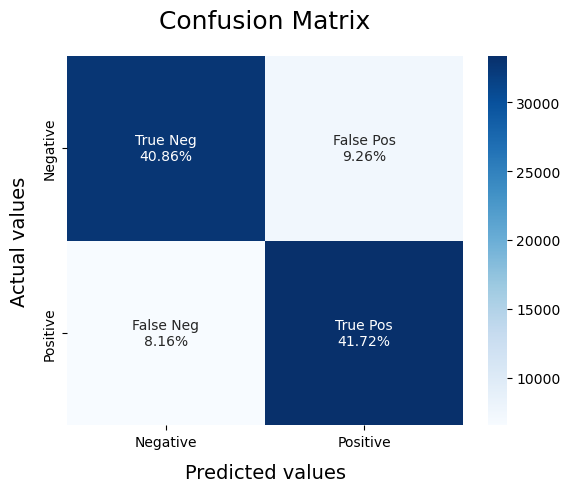

In [84]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

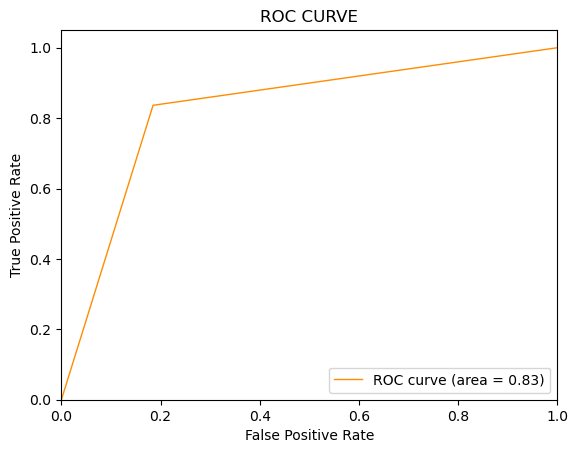

In [85]:
# Plot the ROC-AUC Curve for model-3
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

## Model Evaluation
Upon evaluating all the models, we can conclude the following details i.e.

`Accuracy`: As far as the accuracy of the model is concerned, Logistic Regression performs better than SVM, which in turn performs better than Bernoulli Naive Bayes.

`F1-score`: The F1 Scores for class 0 and class 1 are :

(a) For class 0: Bernoulli Naive Bayes(accuracy = 0.80) < SVM (accuracy =0.82) < Logistic Regression (accuracy = 0.82)

(b) For class 1: Bernoulli Naive Bayes (accuracy = 0.80) < SVM (accuracy = 0.82) < Logistic Regression (accuracy = 0.83)

`AUC Score`: The ROC AUC score of Logistic Regression model (0.83) is larger than rest models, it is the best model we can have.

We, therefore, conclude that the `Logistic Regression` is the best model for the above-given dataset.

## Conclusion
In this project, multiple machine learning models—Bernoulli Naive Bayes, Support Vector Machine (SVM), and Logistic Regression—were evaluated for the task of sentiment classification using TF-IDF-based textual features. Model performance was assessed using accuracy, F1-score, and ROC-AUC, ensuring a comprehensive and balanced evaluation.

The experimental results demonstrate that Logistic Regression consistently outperforms the other models across all evaluation metrics. It achieves the highest overall accuracy, superior F1-scores for both sentiment classes, and the largest ROC-AUC score, indicating better class separability and robustness in prediction. While SVM shows competitive performance and Bernoulli Naive Bayes provides a strong baseline, both fall short of Logistic Regression in terms of overall effectiveness.

Furthermore, Logistic Regression aligns well with the principle of Occam’s Razor, which states that among competing models with comparable performance, the simplest model should be preferred. Given that the dataset does not impose strong distributional assumptions and consists of high-dimensional sparse features generated through TF-IDF, Logistic Regression proves to be an optimal choice by offering a balance of simplicity, interpretability, and predictive performance.

Therefore, based on empirical evaluation and theoretical considerations, `Logistic Regression` is selected as the most suitable and reliable model for the given sentiment analysis task.